In [ ]:
PROTGPS_PARENT_DIR = "/home/protgps"

In [1]:
import sys
import os
sys.path.append(PROTGPS_PARENT_DIR) # append the path of protgps
from argparse import Namespace
import pickle
import copy
import yaml
import requests
from tqdm import tqdm
from p_tqdm import p_map
import numpy as np
import pandas as pd
from collections import defaultdict
import torch 
from captum.attr import LayerIntegratedGradients
from captum.attr import visualization as viz
import protpy
from protpy import amino_acids as protpyAA
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
from protgps.utils.loading import get_object

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Functions

In [18]:
# WHAT'S IN THE LOCAL CODE
COMPARTMENTS = [
    'transcriptional',
    'chromosome',
    'nuclear_pore_complex',
    'nuclear_speckle', 
    'p-body', 
    'pml-bdoy', 
    'post_synaptic_density',
    'stress_granule',
    'nucleolus',
    'cajal_body',
    'rna_granule',
    'cell_junction'
]

# WHAT'S IN THE COMMITTED CODE
# ORDER WAS CHANGED AT SOME POINT!!! 
# USE THE ONE ON GITHUB
# https://github.com/pgmikhael/nox/blob/1e5b963cbfdad23418a98c7c67a11c6431869cf6/nox/datasets/protein_compartments.py
OLDCOMPS = [
    "nuclear_speckle",
    "p-body",
    "pml-bdoy",
    "post_synaptic_density",
    "stress_granule",
    "chromosome",
    "nucleolus",
    "nuclear_pore_complex",
    "cajal_body",
    "rna_granule",
    "cell_junction",
    "transcriptional"
]

def transform_y(y: torch.Tensor):
    # get indices where y is one in, where y is a pytorch tensor
    indices = torch.nonzero(y)
    # convert indices from list1 to equivalent classes in list2
    new_indices = torch.tensor([OLDCOMPS.index(COMPARTMENTS[i]) for i in indices])
    # return binary tensor based on new indices
    return torch.zeros(len(OLDCOMPS)).scatter_(0, new_indices, 1)

In [3]:
UNIPROT_ENTRY_URL = "https://rest.uniprot.org/uniprotkb/{}.fasta"

def get_organism(uni):
    response= requests.get(f"https://rest.uniprot.org/uniprotkb/{uni}.json").json()
    if 'organism' in response:
        return response['organism']['scientificName']
    else:
        return ""
        
def parse_fasta(f):
    """Parse fasta data

    Args:
        f (str): fasta data

    Returns:
        str: protein sequence
    """
    _seq = ""
    for _line in f.split("\n"):
        if _line.startswith(">"):
            continue
        _seq += _line.strip()
    return _seq


def get_protein_fasta(uniprot):
    """Get protein info from uniprot

    Args:
        uniprot (str): uniprot
    """
    fasta = requests.get(UNIPROT_ENTRY_URL.format(uniprot))
    if fasta.status_code == 200:  # Success
        sequence = parse_fasta(fasta.text)
        return sequence
    return

In [157]:
def load_model(snargs):
    """
    Loads classifier model from args file
    """
    modelpath = snargs.model_path
    model = get_object(snargs.lightning_name, "lightning")(snargs)
    model = model.load_from_checkpoint(
        checkpoint_path = modelpath,
        strict=not snargs.relax_checkpoint_matching,
        **{"args": snargs},
    )
    return model, snargs

In [159]:
def predict_condensates(model, sequences, batch_size, round=True):
    scores = []
    for i in tqdm(range(0, len(sequences), batch_size), ncols=100):
        batch = sequences[ i : (i + batch_size)]
        with torch.no_grad():
            out = model.model({"x": batch})    
        s = torch.sigmoid(out['logit']).to("cpu")
        scores.append(s)
    scores = torch.vstack(scores)
    if round:
        scores = torch.round(scores, decimals=3)
    return scores

In [14]:
def get_valid_rows(df, cols):
    rows_with_valid_seq_len = []
    for i in range(len(df)):
        if all([ len(df.iloc[i][c]) < 1800 for c in cols]):
            rows_with_valid_seq_len.append(i)
    return rows_with_valid_seq_len

# Predictions on Additional Data

In [ ]:
args = Namespace(**pickle.load(open(os.path.join(PROTGPS_PARENT_DIR, 'checkpoints/protgps/32bf44b16a4e770a674896b81dfb3729.args'),'rb')))
args.pretrained_hub_dir = "/home/protgps/esm_models/esm2"
model = load_model(args)
model = model[0]
model.eval()
model = model.to(device)

### Condensate

In [ ]:
# Load test dataset
train_dataset = get_object(args.dataset_name, "dataset")(args, "train")
dev_dataset = get_object(args.dataset_name, "dataset")(args, "dev")
test_dataset = get_object(args.dataset_name, "dataset")(args, "test")
train_sequences = set(d['x'] for d in train_dataset.dataset+dev_dataset.dataset)

In [5]:
data = pd.read_excel("Condensate_data_idmapping_2023_11_04.xlsx")

In [14]:
protein_ids = set()
for rowid, row in data.iterrows():
    if isinstance(row['Cluster members'],str):
        entries = row['Cluster members'].split(";")
        entries = [e.split(',')[0].strip() for e in entries]
        protein_ids.update(entries)
        cluster = row['From'].split("_")[0]
        protein_ids.add(cluster)
    elif np.isnan(row['Cluster members']):
        continue 

In [ ]:
sequences = p_map(get_protein_fasta, list(protein_ids))
protein2sequence = {p:s for p,s in zip(protein_ids,sequences)}
pickle.dump(protein2sequence, open("Condensate_data_idmapping_sequences.p", "wb"))

In [7]:
protein_ids = [ p for p, s in protein2sequence.items() if s is not None ]
sequences = [ protein2sequence[p] for p in protein_ids ]

In [ ]:
scores = predict_condensates(model, sequences, batch_size=1)

In [ ]:
scores = torch.vstack(scores)
scores_round = torch.round(scores, decimals=3)

In [8]:
scores_round = torch.load("scores_round.pt")
scores_round, protein_ids_scores = scores_round["scores"], scores_round["protein_ids"]

In [10]:
protein_to_scores = {p:s for p,s in zip(protein_ids_scores,scores_round)}

In [ ]:
organisms = p_map(get_organism, protein_ids_scores)
protein_ids_scores_to_organisms = {p:o for p,o in zip(protein_ids_scores, organisms)}
pickle.dump(protein_ids_scores_to_organisms, open("protein_ids_scores_to_organisms.p", "wb"))

In [59]:
results_df = defaultdict(list)
with tqdm(total=len(data), ncols=100) as tqdm_bar:
    for rowid, row in data.iterrows():
        if isinstance(row['Cluster members'],str):
            entries = row['Cluster members'].split(";")
            entries = [e.split(',')[0].strip() for e in entries]
            for entry in entries:
                if entry in protein_to_scores:
                    sequence = protein2sequence[entry]
                    results_df["ProteinID"].append(entry)
                    results_df["Protein_Split"].append("train" if sequence in train_sequences else "test")
                    results_df["Organism"].append(protein_ids_scores_to_organisms[entry])
                    results_df["original_row"].append(rowid)
                    results_df["gene_names"].append(row["gene_names"])
                    results_df["split"].append(row["split"]) 
                    results_df["labels"].append(row["labels"])
                    results_df["From"].append(row["From"])
                    results_df["Cluster ID"].append(row["Cluster ID"])
                    results_df["Cluster Name"].append(row["Cluster Name"])
                    results_df["Organism IDs"].append(row["Organism IDs"])
                    results_df["Sequence"].append(sequence)
                    score = protein_to_scores[entry]
                    for j,condensate in enumerate(OLDCOMPS):
                        results_df[f"{condensate.upper()}_Score"].append(score[j].item())
        tqdm_bar.update()
               

100%|███████████████████████████████████████████████████████████| 5480/5480 [02:00<00:00, 45.52it/s]


In [61]:
results_df = pd.DataFrame(results_df)

In [62]:
results_df.to_csv("Condensate_data_idmapping_2023_11_04_preds.csv", index=False)

### Substitutions_set_230130

In [10]:
data = pd.read_excel("substitutions_set_230130.xlsx") 

In [11]:
data.head()

,Protein,Mutation,Mendelian_disease,Cancer,Uniprot_ID,WT_Sequence,Substitution_seq
0,1433B,Lys77Gln,NaN,NaN,P31946,MTMDKSELVQKAKLAEQAERYDDMAAAMKAVTEQGHELSNEERNLL...,MTMDKSELVQKAKLAEQAERYDDMAAAMKAVTEQGHELSNEERNLL...
1,1433B,Thr207Met,NaN,NaN,P31946,MTMDKSELVQKAKLAEQAERYDDMAAAMKAVTEQGHELSNEERNLL...,MTMDKSELVQKAKLAEQAERYDDMAAAMKAVTEQGHELSNEERNLL...
2,1433G,Arg132Cys,"AUTISM, DEVELOPMENTAL AND EPILEPTIC ENCEPHALOP...",NaN,P61981,MVDREQLVQKARLAEQAERYDDMAAAMKNVTELNEPLSNEERNLLS...,MVDREQLVQKARLAEQAERYDDMAAAMKNVTELNEPLSNEERNLLS...
3,1433G,Arg132His,"AUTISM, DEVELOPMENTAL AND EPILEPTIC ENCEPHALOP...",NaN,P61981,MVDREQLVQKARLAEQAERYDDMAAAMKNVTELNEPLSNEERNLLS...,MVDREQLVQKARLAEQAERYDDMAAAMKNVTELNEPLSNEERNLLS...
4,1433G,Arg57Cys,"AUTISM, DEVELOPMENTAL AND EPILEPTIC ENCEPHALOP...",NaN,P61981,MVDREQLVQKARLAEQAERYDDMAAAMKNVTELNEPLSNEERNLLS...,MVDREQLVQKARLAEQAERYDDMAAAMKNVTELNEPLSNEERNLLS...


In [13]:
rows_with_valid_seq_len = get_valid_rows(data, ['WT_Sequence', 'Substitution_seq'])

In [15]:
len(data), len(rows_with_valid_seq_len)

(144129, 118068)

In [16]:
data = data.loc[rows_with_valid_seq_len]

In [21]:
sequences = list(data['WT_Sequence'])
scores = predict_condensates(model, sequences, batch_size=10)

100%|█████████████████████████████████████████████████████████| 11807/11807 [48:33<00:00,  4.05it/s]


In [22]:
for j,condensate in enumerate(OLDCOMPS):
    data[f"WT_Sequence_{condensate.upper()}_Score"] = scores[:, j].tolist()

In [23]:
sequences = list(data['Substitution_seq'])
scores = predict_condensates(model, sequences, batch_size=10)

100%|█████████████████████████████████████████████████████████| 11807/11807 [48:31<00:00,  4.06it/s]


In [24]:
for j,condensate in enumerate(OLDCOMPS):
    data[f"Substitution_seq_{condensate.upper()}_Score"] = scores[:, j].tolist()

In [25]:
data.to_csv('substitutions_set_230130_preds.csv', index=False)

### termination_set_230129

In [15]:
data = pd.read_excel("termination_set_230129.xlsx")

In [16]:
data.head()

,Protein,Uniprot_ID,WT_Sequence,Termination_sequence
0,1433G,P61981,MVDREQLVQKARLAEQAERYDDMAAAMKNVTELNEPLSNEERNLLS...,MVDREQLVQKARLAEQAERYDDMAAAMKNVTELNEPLSNEERNLLS...
1,1433Z,P63104,MDKNELVQKAKLAEQAERYDDMAACMKSVTEQGAELSNEERNLLSV...,MDKNELVQKAKLAE
2,1433Z,P63104,MDKNELVQKAKLAEQAERYDDMAACMKSVTEQGAELSNEERNLLSV...,MDKNELVQKAKLAEQAERYDDMAACMKSVTEQGAELSNEERNLLSV...
3,2A5D,Q14738,MPYKLKKEKEPPKVAKCTAKPSSSGKDGGGENTEEAQPQPQPQPQP...,MPYKLKKEKEPPKVAKCTAKPSSSGKDGGGENTEEAQPQPQPQPQP...
4,2A5D,Q14738,MPYKLKKEKEPPKVAKCTAKPSSSGKDGGGENTEEAQPQPQPQPQP...,MPYKLKKEKEPPKVAKCTAKPSSSGKDGGGENTEEAQPQPQPQPQP...


In [17]:
rows_with_valid_seq_len = get_valid_rows(data, ['WT_Sequence', 'Termination_sequence'])

In [18]:
data = data.loc[rows_with_valid_seq_len]

In [19]:
len(data), len(rows_with_valid_seq_len)

(39602, 39602)

In [20]:
sequences = list(data['WT_Sequence'])
scores = predict_condensates(model, sequences, batch_size=5)

100%|███████████████████████████████████████████████████████████| 3961/3961 [17:57<00:00,  3.68it/s]


In [21]:
for j,condensate in enumerate(OLDCOMPS):
    data[f"WT_Sequence_{condensate.upper()}_Score"] = scores[:, j].tolist()

In [22]:
sequences = list(data['Termination_sequence'])
scores = predict_condensates(model, sequences, batch_size=5)

100%|███████████████████████████████████████████████████████████| 3961/3961 [10:26<00:00,  6.32it/s]


In [23]:
for j,condensate in enumerate(OLDCOMPS):
    data[f"Termination_sequence_{condensate.upper()}_Score"] = scores[:, j].tolist()

In [24]:
data.to_csv('termination_set_230129_preds.csv', index=False)

### disease_mutations_reference_set

In [25]:
data = pd.read_excel("disease_mutations_reference_set.xlsx")

In [26]:
data.head()

,Variant,Sequence
0,BARD1 406*,MPDNRQPRNRQPRIRSGNEPRSAPAMEPDGRGAWAHSRAALDRLEK...
1,BCL11A 177*,MSRRKQGKPQHLSKREFSPEPLEAILTDDEPDHGPLGAPEGDHDLL...
2,BCOR 657*,MLSATPLYGNVHSWMNSERVRMCGASEDRKILVNDGDASKARLELR...
3,BRD3 F334S,MSTATTVAPAGIPATPGPVNPPPPEVSNPSKPGRKTNQLQYMQNVV...
4,HP1a V21I,MGKKTKRTADSSSSEDEEEYlVEKVLDRRVVKGQVEYLLKWKGFSE...


In [27]:
rows_with_valid_seq_len = get_valid_rows(data, ['Sequence'])

In [28]:
len(data), len(rows_with_valid_seq_len)

(21, 21)

In [29]:
data = data.loc[rows_with_valid_seq_len]

In [43]:
sequences = [s.upper() for s in list(data['Sequence'])]
scores = predict_condensates(model, sequences, batch_size=5)

100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]


In [46]:
for j,condensate in enumerate(OLDCOMPS):
    data[f"{condensate.upper()}_Score"] = scores[:, j].tolist()

In [48]:
data.to_csv('disease_mutations_reference_set_preds.csv', index=False)

# AUCs

In [7]:
# args
args = Namespace(**pickle.load(open(os.path.join(PROTGPS_PARENT_DIR, 'checkpoints/protgps/32bf44b16a4e770a674896b81dfb3729.args'),'rb')))
args.dataset_file_path = os.path.join(PROTGPS_PARENT_DIR, "data/new_condensate_dataset_m3_c5_mmseqs.json")
# Load test dataset
test_dataset = get_object(args.dataset_name, "dataset")(args, "test")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5480/5480 [00:00<00:00, 28895.76it/s]


TEST DATASET CREATED FOR PROTEIN_CONDENSATES_COMBINED.
Could not produce summary statement


In [10]:
ys = [d['y'] for d in test_dataset.dataset]

In [ ]:
model = load_model(args)
model = model[0]
model.eval()
model = model.to(device)
print()

In [67]:
test_x = [s['x'] for s in test_dataset.dataset]
test_y = [transform_y(s['y']) for s in test_dataset.dataset]
test_id = [s['entry_id'] for s in test_dataset.dataset]

In [70]:
test_preds = predict_condensates(model, test_x, 10, round=False)

100%|███████████████████████████████████████████████████████████████| 81/81 [00:20<00:00,  3.97it/s]


In [74]:
test_y = torch.vstack(test_y)

In [78]:
for j,condensate in enumerate(OLDCOMPS):
    auc = roc_auc_score(test_y[:,j], test_preds[:,j])
    print(f"{condensate}:\t{round(auc,3)}")

nuclear_speckle:	0.905
p-body:	0.887
pml-bdoy:	0.768
post_synaptic_density:	0.872
stress_granule:	0.83
chromosome:	0.921
nucleolus:	0.92
nuclear_pore_complex:	0.987
cajal_body:	0.9
rna_granule:	1.0
cell_junction:	0.925
transcriptional:	0.869


# Analysis

In [11]:
experimental_sequences = [
    {
        "condensate": "nucleolus",
        "name": "mc2_nuc1",
        "seed": 6,
        "sequence": "FMLVSTLWWKQKRLNNAVRTHTKFLTTINNPWRDFCSHRKKYCQKRKHEHATLKSWGTNNGSRRAAGICSGYGPEHSPDANTVKHCCIDYDSIDPIRCTR"
    },
    {
        "condensate": "nucleolus",
        "name": "mc2_nuc2",
        "seed": 1,
        "sequence": "HFMRIADRKVMHHGCAKQGNSWNHIGQKPCCSKVKKGEQSQKADAVVWGVKCHMKWEARSQCNQSFEKMQLHCPMSCRVQESSHNQHNIQPKANHQAMIH"
    },
    {
        "condensate": "nucleolus",
        "name": "mc2_nuc7",
        "seed": 7,
        "sequence": "HGQNRRRKNIGTLKMHTIRGFFPMFSEIRNNHTFTIHGSKSFNSDFQDQNLHCHDRMMHLQISDSMNNTGEEWMTEKVNSLPRKGKSGGPPYKPKVWSVQ"
    },
    {
        "condensate": "nuclear_speckle",
        "name": "mc2_spk2",
        "seed": 8,
        "sequence": "VNDITDVEMAVGRVPREGGNATERCYACFHHLDDYDLHQQMHGRDAPHMRNNSYKKAAHSEHINEVDHQGLQSDVEEYEGVMNEDTFKYMADERDCSPRN"
    },
    {
        "condensate": "nuclear_speckle",
        "name": "mc2_spk3",
        "seed": 7,
        "sequence": "TKIKKHRSTPNMIQSPVTYPDEDHTNNHAGWKTTKAAAPKFRCAARQINRTAMMRCENFAITIDDMPSQDWPHKDDHGAGDDKKDCMPARYDGHTEETND"
    },
    
]

In [12]:
mcherry = 'LVQLVHAAGGVAALGAFVLFHDGVVLVVGKDVQLDVDVVGAGQLHGLLGLVGGLDLSVVVAAVLQLQPLLDLALQGAVLGVHPLSGGLPAHGTTLHYGAVGGEVGAAQLHLVDELAVLQGGVLGHGHHAAVLEVHHALPIEALGEGQLQVVGDVGGVLHVGLGAVHELRGQDVPGEGQGATLGHLQLGGLGALVGAALALALDLELVAVHGALHVHLEAHELLDDGHVILLALAH'

## Integrated Gradients | Attributions

In [49]:
def visualize_text(datarecords, legend: bool = True) -> "HTML":  # In quotes because this type doesn't exist in standalone mode
    dom = ["<table width: 100%>"]
    rows = [
        #"<tr><th>True Label</th>"
        #"<th>Attribution Label</th>"
        #"<th>Attribution Score</th>"
        "<th>Amino Acid Importance</th>" #"<th>Word Importance</th>"
        "<th>Sample ID</th>"
        "<th>Target (score)</th>"#"<th>Predicted Label</th>"
    ]
    for datarecord in datarecords:
        rows.append(
            "".join(
                [
                    "<tr>",
                    # format_classname(datarecord.true_class),
                    #format_classname(datarecord.attr_class),
                    # format_classname("{0:.2f}".format(datarecord.attr_score)),
                    viz.format_word_importances(
                        datarecord.raw_input_ids, datarecord.word_attributions
                    ),
                    viz.format_classname(datarecord.true_class.split('_')[1]),
                    viz.format_classname(
                        "{0} ({1:.2f})".format(
                            datarecord.pred_class, datarecord.pred_prob
                        )
                    ),
                    
                    "<tr>",
                ]
            )
        )

    if legend:
        dom.append(
            '<div style="border-top: 1px solid; margin-top: 5px; \
            padding-top: 5px; display: inline-block">'
        )
        dom.append("<b>Legend: </b>")

        for value, label in zip([-1, 0, 1], ["Negative", "Neutral", "Positive"]):
            dom.append(
                '<span style="display: inline-block; width: 10px; height: 10px; \
                border: 1px solid; background-color: \
                {value}"></span> {label}  '.format(
                    value=viz._get_color(value), label=label
                )
            )
        dom.append("</div>")

    dom.append("".join(rows))
    dom.append("</table>")
    html = viz.HTML("".join(dom))
    viz.display(html)

    return html

In [50]:
def forward(batch_tokens):
    model.zero_grad()
    result = model.model.encoder.model(batch_tokens, repr_layers = [model.model.encoder.repr_layer], return_contacts=False)
    hidden = result["representations"][model.model.encoder.repr_layer].mean(axis=1)
    scores = torch.sigmoid(model.model.mlp({'x': hidden})["logit"])
    return scores

In [51]:
model = model.to('cpu')

In [52]:
alphabet = model.model.encoder.alphabet

In [53]:
lig = LayerIntegratedGradients(forward, model.model.encoder.model.embed_tokens)

In [54]:
records = []
sequence_dict_copy = copy.deepcopy(experimental_sequences)
for sequence_dict in sequence_dict_copy:
    seq = sequence_dict['sequence']
    input_seq = seq +  mcherry

    # baseline
    baseline = torch.tensor([alphabet.cls_idx] + [alphabet.mask_idx] * len(input_seq) + [alphabet.eos_idx]).unsqueeze(0)

    # inputs 
    fair_x = [(0, input_seq)] 
    _, _, batch_tokens = model.model.encoder.batch_converter(fair_x)

    # get prediction
    with torch.no_grad():
        model.eval()
        out = model.model({'x': [input_seq] })
    probs = torch.sigmoid(out['logit']).detach().cpu()
    pred_class = probs.argmax().item()
    pred_class_name = OLDCOMPS[ pred_class ]

    assert pred_class_name == sequence_dict["condensate"]

    # get attribution
    attributions, delta = lig.attribute(
            inputs=batch_tokens,
            baselines=baseline,
            return_convergence_delta=True,
            target = pred_class,
            n_steps=50,
        )
    A = attributions.sum(-1)[0, 1:-1]
    A = A / torch.norm(A)
    sequence_dict["attributions"] = A.tolist()

    # visualize
    record = viz.VisualizationDataRecord(
            word_attributions = A * 10,
            pred_prob = probs.max().item(),
            pred_class = pred_class_name,
            true_class = sequence_dict["name"],
            attr_class = "-",
            attr_score = attributions[0, 1:-1].sum(),
            raw_input_ids= input_seq,
            convergence_score = delta,
        )
    records.append(record)

In [55]:
html = visualize_text(records)

nuc1,nucleolus (0.90)
nuc2,nucleolus (0.93)
nuc7,nucleolus (0.95)


In [56]:
with open('html_file.html', 'w') as f:
    f.write(html.data)

In [57]:
for sequence_dict in sequence_dict_copy:
    seq = sequence_dict['sequence']
    sequence_dict['full_sequence'] = seq +  mcherry

In [58]:
pd.DataFrame(sequence_dict_copy).to_csv('attributions.csv', index=False)

## Trajectories

In [27]:
paths = []
for root,_,files in os.walk(os.path.join(esm_directory, "trajectories")):
    paths.extend([ os.path.join(root, f) for f in files if f.endswith('.txt')])


idr2scores = defaultdict(list)
preds = []
for p in paths:
    config = os.path.join(os.path.dirname(p), ".hydra/config.yaml")
    with open(config, 'r') as file:
        config = yaml.safe_load(file)
    condensate = p.split('/')[-1].split('.')[0]
    with open(p, 'r') as f:
        preds = f.readlines()
    preds = [p.strip('\n') for p in preds]
    idr2scores[f"{condensate}_{config['seed']}"].extend([p.split('\t') for p in preds])

In [28]:
idr2scores.keys()

dict_keys(['nuclear_speckle_7', 'nucleolus_7', 'nuclear_speckle_8', 'nucleolus_6', 'nucleolus_1'])

In [30]:
trajectories = defaultdict(list)

In [47]:
for generated, traj in idr2scores.items():
    
    target, seed = generated[:-2], generated[-1]
    trajectory = [(int(i.split(':')[0]), s, float(p)) for i,s,p in traj ]
    trajectory = sorted(trajectory, key = lambda x: x[0])
    
    steps = [s[0] for s in trajectory]
    seqs = [s[1] for s in trajectory]
    scores = [s[2] for s in trajectory]
    
    trajectories["Target Compartment"].extend( [target] * len(steps) )
    trajectories["Seed"].extend([seed] * len(steps))
    trajectories["Step"].extend(steps)
    trajectories["IDR Sequence"].extend(seqs)
    trajectories["Localization Score"].extend(scores)

In [48]:
pd.DataFrame(trajectories).to_csv('trajectories.csv', index=False)

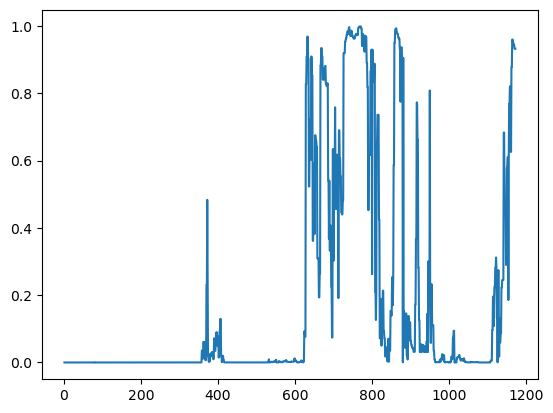

In [271]:
plt.plot( [i[0] for i in trajectory], [i[-1] for i in trajectory])
plt.show()

# Revisions

In [6]:
# model
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.metrics import roc_auc_score

In [7]:
def make_features(sequence):
    features = [protpy.amino_acid_composition(sequence)]
    for key in ["hydrophobicity", "polarity", "charge", "solvent_accessibility", "polarizability"]:
        features.extend([
            protpy.ctd_composition(sequence, property=key),
            protpy.ctd_transition(sequence, property=key),
            protpy.ctd_distribution(sequence, property=key)
        ])  
    features = pd.concat(features, axis=1)
    features = np.array(features)
    return features

## Classic Model

In [3]:
args = Namespace(**pickle.load(open(os.path.join(PROTGPS_PARENT_DIR, 'checkpoints/protgps/32bf44b16a4e770a674896b81dfb3729.args'),'rb')))
args.pretrained_hub_dir = "/home/protgps/esm_models/esm2"
args.dataset_file_path = os.path.join(PROTGPS_PARENT_DIR, "data/new_condensate_dataset_m3_c5_mmseqs.json")

In [4]:
train_dataset = get_object(args.dataset_name, "dataset")(args, "train")
dev_dataset = get_object(args.dataset_name, "dataset")(args, "dev")
test_dataset = get_object(args.dataset_name, "dataset")(args, "test")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5480/5480 [00:00<00:00, 19211.00it/s]


TRAIN DATASET CREATED FOR PROTEIN_CONDENSATES_COMBINED.
Could not produce summary statement


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5480/5480 [00:00<00:00, 31098.76it/s]


DEV DATASET CREATED FOR PROTEIN_CONDENSATES_COMBINED.
Could not produce summary statement


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5480/5480 [00:00<00:00, 24179.16it/s]

TEST DATASET CREATED FOR PROTEIN_CONDENSATES_COMBINED.
Could not produce summary statement


In [55]:
train_data_classic = []
for sample in tqdm(train_dataset.dataset, ncols=100):
    if any(k not in protpyAA for k in sample['x']):
        continue
    train_data_classic.append({
        "x": make_features(sample['x']),
        'y': sample['y'],
    })

100%|███████████████████████████████████████████████████████████| 3766/3766 [01:29<00:00, 42.18it/s]


In [64]:
trainX = np.concatenate([d['x'] for d in train_data_classic])
trainY = np.stack([d['y'] for d in train_data_classic])

In [68]:
test_data_classic = []
for sample in tqdm(test_dataset.dataset, ncols=100):
    if any(k not in protpyAA for k in sample['x']):
        continue
    test_data_classic.append({
        "x": make_features(sample['x']),
        'y': sample['y'],
    })

100%|█████████████████████████████████████████████████████████████| 803/803 [00:18<00:00, 43.05it/s]


In [69]:
len(test_data_classic), len(test_dataset.dataset)

(799, 803)

In [70]:
testX = np.concatenate([d['x'] for d in test_data_classic])
testY = np.stack([d['y'] for d in test_data_classic])

In [109]:
# RANDOM FOREST
rf =  RandomForestClassifier(
    n_estimators=100,
    max_depth=400, 
    random_state=0, 
)

multi_target_rf = ClassifierChain(rf)
multi_target_rf.fit(trainX, trainY)
predY = multi_target_rf.predict_proba(testX)

for i, c in enumerate(OLDCOMPS):
    auc = roc_auc_score(testY[:,i], predY[:,i])
    print(f"ROC-AUC {c}: {auc}")

ROC-AUC nuclear_speckle: 0.8611388611388612
ROC-AUC p-body: 0.7530266343825666
ROC-AUC pml-bdoy: 0.5554846938775511
ROC-AUC post_synaptic_density: 0.7673996302165874
ROC-AUC stress_granule: 0.6580655957161983
ROC-AUC chromosome: 0.7941110917301395
ROC-AUC nucleolus: 0.825681905493661
ROC-AUC nuclear_pore_complex: 0.8468906842942833
ROC-AUC cajal_body: 0.6639344262295082
ROC-AUC rna_granule: 1.0
ROC-AUC cell_junction: 0.8344669543382335
ROC-AUC transcriptional: 0.7089917825537295


In [113]:
# Logistic Regression
logreg =  LogisticRegression(solver="liblinear", random_state=0)

multi_target_lr = ClassifierChain(logreg)
multi_target_lr.fit(trainX, trainY)
predY = multi_target_lr.predict_proba(testX)

for i, c in enumerate(OLDCOMPS):
    auc = roc_auc_score(testY[:,i], predY[:,i])
    print(f"ROC-AUC {c}: {auc}")

ROC-AUC nuclear_speckle: 0.7397768897768897
ROC-AUC p-body: 0.6447119264915877
ROC-AUC pml-bdoy: 0.5536139455782313
ROC-AUC post_synaptic_density: 0.7415525243377858
ROC-AUC stress_granule: 0.6493250780901383
ROC-AUC chromosome: 0.692142954047716
ROC-AUC nucleolus: 0.6520745293891663
ROC-AUC nuclear_pore_complex: 0.8626820908311912
ROC-AUC cajal_body: 0.8215636822194199
ROC-AUC rna_granule: 0.9943538268506901
ROC-AUC cell_junction: 0.7129988541895219
ROC-AUC transcriptional: 0.5559418457648546


## MMSeqs

In [9]:
args = Namespace(**pickle.load(open(os.path.join(PROTGPS_PARENT_DIR, 'checkpoints/protgps/7c4853cd22080b250ef89af2a1b25102.args'),'rb')))
args.from_checkpoint = True
args.checkpoint_path = os.path.join(PROTGPS_PARENT_DIR,"checkpoints/protgps/7c4853cd22080b250ef89af2a1b25102epoch=3.ckpt")
args.model_path = args.checkpoint_path
args.pretrained_hub_dir = "/home/protgps/esm_models/esm2"
args.dataset_file_path = os.path.join(PROTGPS_PARENT_DIR, "data/new_condensate_dataset_m3_c5_mmseqs.json")

In [ ]:
model = load_model(args)
model = model[0]
model.eval()
print()

In [269]:
test_dataset = get_object(args.dataset_name, "dataset")(args, "test")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5480/5480 [00:00<00:00, 28547.10it/s]


TEST DATASET CREATED FOR PROTEIN_CONDENSATES_COMBINED.
Could not produce summary statement


In [270]:
test_x = [s['x'] for s in test_dataset.dataset]
test_y = [s['y'] for s in test_dataset.dataset]
test_id = [s['entry_id'] for s in test_dataset.dataset]
test_y = torch.vstack(test_y)

In [280]:
test_preds = predict_condensates(model, test_x, 1, round=False)

100%|█████████████████████████████████████████████████████████████| 803/803 [01:24<00:00,  9.50it/s]


In [283]:
for j,condensate in enumerate(OLDCOMPS):
    auc = roc_auc_score(test_y[:,j], test_preds[:,j])
    print(f"{condensate}:\t{round(auc,3)}")

nuclear_speckle:	0.759
p-body:	0.688
pml-bdoy:	0.614
post_synaptic_density:	0.766
stress_granule:	0.619
chromosome:	0.663
nucleolus:	0.796
nuclear_pore_complex:	0.855
cajal_body:	0.646
rna_granule:	0.964
cell_junction:	0.727
transcriptional:	0.605


### classical models

In [12]:
train_dataset = get_object(args.dataset_name, "dataset")(args, "train")
dev_dataset = get_object(args.dataset_name, "dataset")(args, "dev")
test_dataset = get_object(args.dataset_name, "dataset")(args, "test")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5480/5480 [00:00<00:00, 17356.74it/s]


TRAIN DATASET CREATED FOR PROTEIN_CONDENSATES_COMBINED.
Could not produce summary statement


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5480/5480 [00:00<00:00, 42154.20it/s]


DEV DATASET CREATED FOR PROTEIN_CONDENSATES_COMBINED.
Could not produce summary statement


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5480/5480 [00:00<00:00, 31194.95it/s]


TEST DATASET CREATED FOR PROTEIN_CONDENSATES_COMBINED.
Could not produce summary statement


In [13]:
train_data_classic = []
for sample in tqdm(train_dataset.dataset, ncols=100):
    if any(k not in protpyAA for k in sample['x']):
        continue
    train_data_classic.append({
        "x": make_features(sample['x']),
        'y': sample['y'],
    })

trainX = np.concatenate([d['x'] for d in train_data_classic])
trainY = np.stack([d['y'] for d in train_data_classic])

100%|███████████████████████████████████████████████████████████| 3737/3737 [01:10<00:00, 53.36it/s]


In [14]:
test_data_classic = []
for sample in tqdm(test_dataset.dataset, ncols=100):
    if any(k not in protpyAA for k in sample['x']):
        continue
    test_data_classic.append({
        "x": make_features(sample['x']),
        'y': sample['y'],
    })

testX = np.concatenate([d['x'] for d in test_data_classic])
testY = np.stack([d['y'] for d in test_data_classic])

100%|█████████████████████████████████████████████████████████████| 810/810 [00:14<00:00, 55.78it/s]


In [15]:
len(test_data_classic), len(test_dataset.dataset)

(807, 810)

In [19]:
# RANDOM FOREST
rf =  RandomForestClassifier(
    n_estimators=100,
    max_depth=400, 
    random_state=0, 
)

multi_target_rf = ClassifierChain(rf)
multi_target_rf.fit(trainX, trainY)
predY = multi_target_rf.predict_proba(testX)

for i, c in enumerate(OLDCOMPS):
    auc = roc_auc_score(testY[:,i], predY[:,i])
    print(f"ROC-AUC {c}: {auc}")

ROC-AUC nuclear_speckle: 0.744546080832823
ROC-AUC p-body: 0.6188677361379219
ROC-AUC pml-bdoy: 0.5492851084454138
ROC-AUC post_synaptic_density: 0.7177075855467816
ROC-AUC stress_granule: 0.6676669599463718
ROC-AUC chromosome: 0.674722594935361
ROC-AUC nucleolus: 0.7367739782768779
ROC-AUC nuclear_pore_complex: 0.9280735107731305
ROC-AUC cajal_body: 0.6202311333890281
ROC-AUC rna_granule: 0.9978260869565218
ROC-AUC cell_junction: 0.7836348434174522
ROC-AUC transcriptional: 0.7077568134171908


In [20]:
# Logistic Regression
logreg =  LogisticRegression(solver="liblinear", random_state=0)

multi_target_lr = ClassifierChain(logreg)
multi_target_lr.fit(trainX, trainY)
predY = multi_target_lr.predict_proba(testX)

for i, c in enumerate(OLDCOMPS):
    auc = roc_auc_score(testY[:,i], predY[:,i])
    print(f"ROC-AUC {c}: {auc}")

ROC-AUC nuclear_speckle: 0.7686007348438457
ROC-AUC p-body: 0.5427843972575385
ROC-AUC pml-bdoy: 0.5874530473767114
ROC-AUC post_synaptic_density: 0.759069155300311
ROC-AUC stress_granule: 0.6214544578515167
ROC-AUC chromosome: 0.6326699039464997
ROC-AUC nucleolus: 0.6008318759204713
ROC-AUC nuclear_pore_complex: 0.7758766370933672
ROC-AUC cajal_body: 0.4980506822612085
ROC-AUC rna_granule: 0.9677018633540373
ROC-AUC cell_junction: 0.7314685314685316
ROC-AUC transcriptional: 0.67479035639413


In [30]:
protpy.ctd_distribution(sample['x']).to_dict()

{'CTD_D_01_001_hydrophobicity': {0: 0.719},
 'CTD_D_01_025_hydrophobicity': {0: 19.964},
 'CTD_D_01_050_hydrophobicity': {0: 37.41},
 'CTD_D_01_075_hydrophobicity': {0: 67.266},
 'CTD_D_01_100_hydrophobicity': {0: 99.82},
 'CTD_D_02_001_hydrophobicity': {0: 0.36},
 'CTD_D_02_025_hydrophobicity': {0: 24.281},
 'CTD_D_02_050_hydrophobicity': {0: 54.137},
 'CTD_D_02_075_hydrophobicity': {0: 77.338},
 'CTD_D_02_100_hydrophobicity': {0: 99.64},
 'CTD_D_03_001_hydrophobicity': {0: 0.18},
 'CTD_D_03_025_hydrophobicity': {0: 34.173},
 'CTD_D_03_050_hydrophobicity': {0: 58.453},
 'CTD_D_03_075_hydrophobicity': {0: 79.137},
 'CTD_D_03_100_hydrophobicity': {0: 100.0}}